# FERC enforcement analysis

By [Ben Welsh](mailto:ben.welsh@latimes.com)

The _Los Angeles Times_ conducted an analysis of civil penalties issued by the Federal Energy Regulatory Commission for the Dec. 14, 2017 story ["Why Wall Street gets a cut of your California power bill."](http://www.latimes.com/projects/a-fi-electricity-capacity-investments/)

It found that federal regulators have assessed $1.6 billion in penalties against traders, banks, utilities, power producers and grid operators for various violations since anti-manipulation laws were enacted by Congress in 2005. More than a third of the assessed penalties have been tied to California’s energy market.

## How we did it

### Gather enforcement actions from the FERC website

Run a seperate notebook that "scrapes" annual lists of civil penalty actions from the [FERC website](https://www.ferc.gov/enforcement/civil-penalties/civil-penalty-action.asp). It combines them into [a single comma-delimited file](https://github.com/datadesk/ferc-enforcement-analysis/blob/master/input/scraped-ferc-civil-penalties.csv).

In [91]:
%%capture
%run 01_scrape.ipynb

### Research and refine source data

The comma-delimited file was converted into [a Microsoft Excel spreadsheet](https://github.com/datadesk/ferc-enforcement-analysis/blob/master/output/scraped-ferc-civil-penalties.xlsx) and refined outside of this computer programming routine. Each penalty's subject and size was manually extracted. Duplicates were marked for removal. Cases related to California's market were identified and logged. 

The Times then submitted its work to officials at FERC's Office of Enforcement for review. Their response concurred with our results.

<img style="float: left;" src="input/email.png">

### Import Python tools for analysis

In [92]:
import random
import squarify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [93]:
import warnings
warnings.simplefilter("ignore")

In [94]:
%matplotlib inline

### Read in the cleaned data 

In [95]:
df = pd.read_excel("./output/scraped-ferc-civil-penalties.xlsx")

### How many penalties have been issued?

Count the total number of records

In [96]:
len(df)

133

Filter out the duplicates

In [97]:
analysis_df = df[~(df.is_duplicate == 'y')]

Count the "real" total of penalties

In [98]:
len(analysis_df)

114

### What is the total penalty sum?

In [99]:
"{:,.0f}".format(analysis_df.clean_penalty.sum())

'1,613,984,835'

### How have the count and sum varied over time?

Group and calculate both totals

In [100]:
annual_totals = analysis_df.groupby("raw_year").agg(
    dict(
        raw_subject="count",
        clean_penalty="sum"
    )
).reset_index()

Clean up the headers

In [101]:
annual_totals.columns = ['year', 'penalty_sum', 'penalty_count']

Create a pair of charts

Text(0,0.5,u'Millions of dollars')

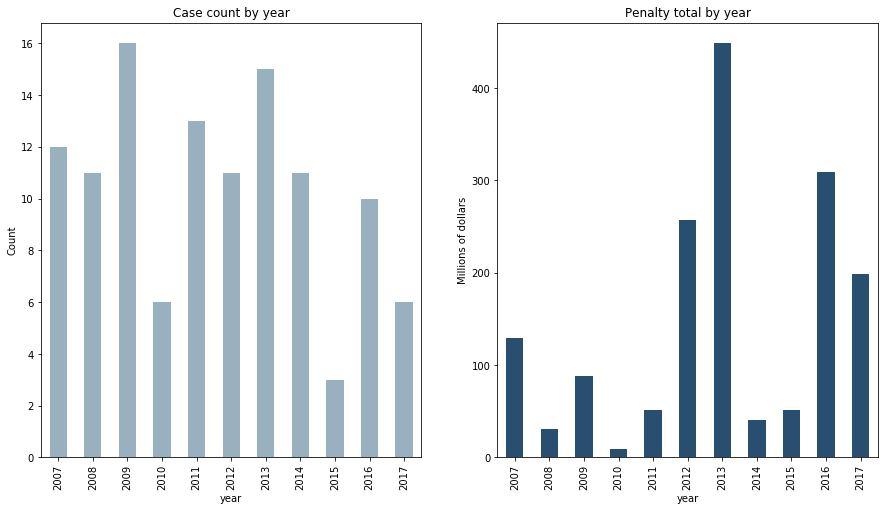

In [102]:
# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(15,8))

# First counts
annual_totals.set_index("year").penalty_count.plot.bar(color="#99B1BE", ax=axs[0], label="count")
ax1 = axs[0].set_title("Case count by year")
axs[0].set_ylabel("Count")

# Then totals
(annual_totals.set_index("year").penalty_sum / 1000000).plot.bar(color="#294F70", ax=axs[1], label="sum")
axs[1].set_title("Penalty total by year")
axs[1].set_ylabel("Millions of dollars")

### What share of the penalties are connected to California?

Filter down to those linked to California

In [103]:
is_california = analysis_df[analysis_df.is_california == 'y']

Count them

In [104]:
len(is_california)

11

Calculate the percentage

In [105]:
"{:.2}%".format(is_california.clean_penalty.sum() / analysis_df.clean_penalty.sum())

'0.35%'

### Visualize cases as a treemap

Resort the data to cluster the california cases together and omit cases with no penalty

In [106]:
treemap_df = analysis_df[analysis_df.clean_penalty > 0].sort_values(
    ["is_california", "clean_penalty"],
    ascending=[True, False]
)

Color in California penalties different from the rest.

In [114]:
def get_treemap_color(row):
    """
    Returns a color value for the provided row.
    """
    # A different color map for each group
    cmap_dict = {
        'y': matplotlib.cm.Blues,
        'n': matplotlib.cm.Reds
    }
    
    # The range of values in each set
    df_dict = {
        'y': treemap_df[treemap_df.is_california == row.is_california],
        'n': treemap_df[treemap_df.is_california == row.is_california]
    }
    
    # Pull out the color ramp for the provided value
    cmap = cmap_dict[row.is_california]
    
    # Pull out the data range the provided value belongs with
    df = df_dict[row.is_california]
    
    # Create a normalize to scale values within that range between 0 and 1.
    normalizer = matplotlib.colors.Normalize(vmin=df.clean_penalty.min(), vmax=df.clean_penalty.max())
    
    # Normalize the provided value
    normed_value = normalizer(row.clean_penalty)
    
    # Set a floor below which we will not let the scale go
    if normed_value < 0.3:
        # But give these a little twitch so we can tell them apart
        # because the treemap library doesn't have a stroke between boxes
        normed_value = random.choice(pd.np.arange(0.1, 0.3, 0.001))
    
    # Return the normed value's position on the color map
    return cmap(normed_value)

In [115]:
treemap_df['treemap_color'] = treemap_df.apply(get_treemap_color, axis=1)

Only show labels for the bigger boxes where they will fit

In [116]:
treemap_df['treemap_label'] = treemap_df.apply(
    lambda x: x.clean_subject if x.clean_penalty > 7500000.0 else '',
    axis=1
)

Plot the treemap

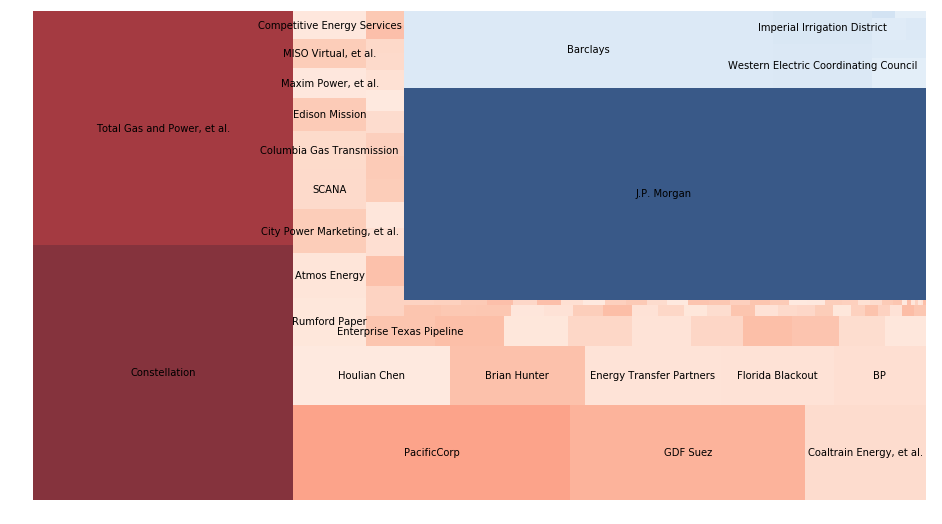

In [117]:
fig = plt.figure(figsize=(16, 9))
squarify.plot(
    sizes=treemap_df.clean_penalty,
    color=treemap_df.treemap_color,
    label=treemap_df.treemap_label,
    alpha=.8
)
ax = plt.axis('off')

### Write out a trimmed and cleaned list of cases ready for publication

In [111]:
public_df = analysis_df[[
    'raw_year',
    'clean_subject',
    'clean_penalty',
    'is_california'
]].sort_values(
    ["is_california", "clean_penalty"],
    ascending=[True, False]
)

In [112]:
public_df.columns = [
    'Year',
    'Subject',
    'Penalty',
    'Linked to Calif.'
]

In [113]:
public_df.to_csv(
    "./output/cleaned-ferc-civil-penalties.csv",
    index=False,
    encoding="utf-8"
)